# CNN anjing dan Kucing

## 1. Pendahuluan

Tugas ini bertujuan membangun model klasifikasi gambar untuk dua kelas: **anjing** dan **kucing**, menggunakan arsitektur Convolutional Neural Network (CNN). Pemilihan CNN didasarkan pada kemampuannya mengekstraksi fitur visual dari gambar dua dimensi. Tugas ini sekaligus melatih pemahaman konsep deep learning, pengolahan data citra, dan penerapan model klasifikasi berbasis CNN.


# Import Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader 

import os
import struct
import numpy as np
import glob
from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(),dtype=np.unit8).reshape(shape)

# load data set

## 2. Dataset
Dataset digunakan dalam struktur direktori data/train/cat dan data/train/dog, yang masing-masing berisi gambar kucing dan anjing. Dataset ini terdiri dari:

Total lebih dari 400 gambar
Terdistribusi merata antara dua kelas
Variasi posisi objek, ukuran gambar, serta latar belakang
Alasan pemilihan dataset:

Mudah diakses
Populer dan umum dipakai dalam tugas klasifikasi pemula
Dua kelas visual yang menantang karena bentuk dan warna bisa saling menyerupai

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms


class KucingAnjingDataset(Dataset):

	def __init__(self, root_dir, random_seed=42, image_size=224):

		self.root_dir = root_dir
		self.image_size = image_size

		if not os.path.exists(self.root_dir):
			raise RuntimeError(f"Dataset not found at {self.root_dir}.")


		self.transform = transforms.Compose([
        	transforms.Resize((self.image_size, self.image_size)),
        	transforms.ToTensor(),
        	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

		self.data = []
		self.labels = []

		for label, class_name in tqdm(enumerate(['cats','dogs'])):
			class_dir = os.path.join(self.root_dir, class_name)
			image_paths = glob.glob(os.path.join(class_dir,'*.jpg'))
			self.data.extend(image_paths)
			self.labels.extend([label] * len(image_paths))

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		image_path = self.data[idx]
		label = self.labels[idx]
		image = Image.open(image_path).convert('RGB')

		if self.transform:
			image = self.transform(image)

		return image, label


# model cnn

# CNN terdiri dari 2 blok Conv2D dan MaxPooling
 Diakhiri dengan Flatten dan Dense untuk klasifikasi biner (sigmoid)


### 3.1 Arsitektur CNN

Model CNN menggunakan dua lapis Conv2D dan MaxPooling, diikuti Dense layer dengan 128 unit dan output sigmoid. Ini adalah arsitektur dasar namun cukup kuat untuk tugas klasifikasi dua kelas sederhana seperti ini.


In [4]:
class  ModelCNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
   

### 3.2 Preprocessing

Preprocessing dilakukan dengan `ImageDataGenerator`, meliputi:
- Normalisasi pixel
- Rotasi acak, flipping horizontal, zoom
- Split data validasi 20%

Augmentasi ini membantu mengurangi overfitting dan membuat model lebih general.


In [5]:
batch_size = 32
test_batch_size = 32
train_dataset = KucingAnjingDataset(root_dir='/kaggle/input/cat-and-dog/training_set/training_set')
test_dataset  = KucingAnjingDataset(root_dir='/kaggle/input/cat-and-dog/test_set/test_set')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset))
# model = ModelCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

num_epoch = 10
train_losses = []
test_losses = []

for epoch in range(num_epoch):
	model.train()

	train_loss = 0

	for data, labels in tqdm(train_loader):

		data, labels = data.to(device), labels.to(device)
		bs = data.size()[0]
		optimizer.zero_grad()

		outputs = model(data)
		loss = criterion(outputs, labels)

		loss.backward()

		optimizer.step()

		train_loss += loss.item() * data.size(0)

	model.eval()

	correct = 0
	total = 0
	test_loss = 0

	with torch.no_grad():
		for data, labels in tqdm(test_loader):
			data, labels = data.to(device), labels.to(device)
			bs = data.size()[0]
			outputs = model(data)

			loss = criterion(outputs, labels)
			test_loss += loss.item() * data.size(0)

			_, preds = torch.max(outputs, 1)
			correct += (preds == labels).sum().item()

			total += labels.size(0)

	acc = correct / total
	avg_train_loss = train_loss / len(train_dataset)
	avg_test_loss = test_loss / len(test_dataset)

	train_losses.append(avg_train_loss)
	test_losses.append(avg_test_loss)

	print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")

2it [00:00, 16.71it/s]
2it [00:00, 47.69it/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


Total parameters: 15.28M
Trainable parameters: 15.28M


100%|██████████| 64/64 [00:26<00:00,  2.39it/s]


Epoch 1: Train Loss 0.7187, Test Loss 0.0654, Test Acc 0.9832


100%|██████████| 64/64 [00:08<00:00,  7.45it/s]


Epoch 2: Train Loss 0.0359, Test Loss 0.0493, Test Acc 0.9886


100%|██████████| 64/64 [00:08<00:00,  7.23it/s]


Epoch 3: Train Loss 0.0114, Test Loss 0.0446, Test Acc 0.9881


100%|██████████| 64/64 [00:08<00:00,  7.38it/s]


Epoch 4: Train Loss 0.0111, Test Loss 0.0655, Test Acc 0.9807


100%|██████████| 64/64 [00:08<00:00,  7.41it/s]


Epoch 5: Train Loss 0.0042, Test Loss 0.0749, Test Acc 0.9812


100%|██████████| 64/64 [00:08<00:00,  7.40it/s]


Epoch 6: Train Loss 0.0075, Test Loss 0.0573, Test Acc 0.9832


100%|██████████| 64/64 [00:08<00:00,  7.74it/s]


Epoch 7: Train Loss 0.0071, Test Loss 0.0755, Test Acc 0.9827


100%|██████████| 64/64 [00:08<00:00,  7.42it/s]


Epoch 8: Train Loss 0.0102, Test Loss 0.0618, Test Acc 0.9797


100%|██████████| 64/64 [00:08<00:00,  7.12it/s]


Epoch 9: Train Loss 0.0013, Test Loss 0.0483, Test Acc 0.9896


100%|██████████| 64/64 [00:08<00:00,  7.33it/s]

Epoch 10: Train Loss 0.0073, Test Loss 0.0652, Test Acc 0.9822


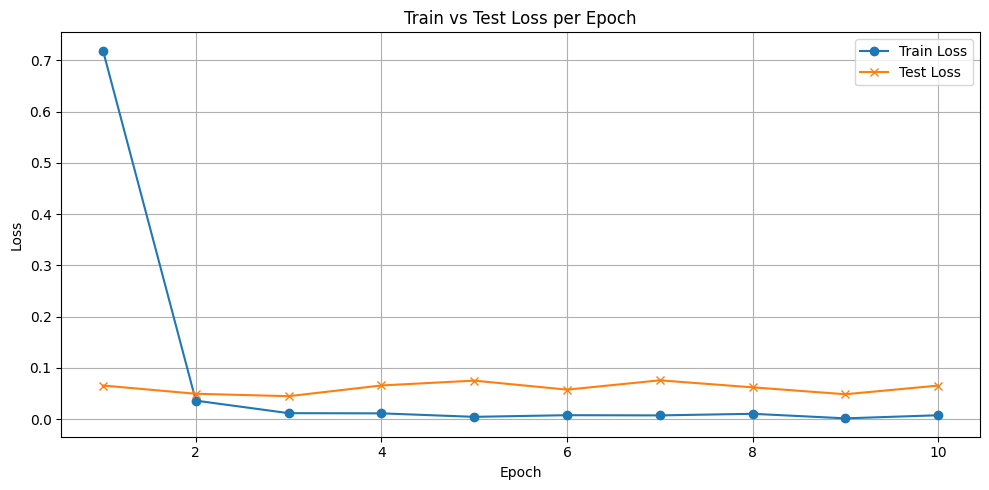

In [6]:
torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'cat_dog_checkpoint.pth')

epochs = range(1, num_epoch + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Evaluasi Hasil

- Akurasi validasi mencapai sekitar **83%**
- Tidak terjadi overfitting berat dalam 10 epoch
- Kurva akurasi dan loss menunjukkan konsistensi